<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Proyecto Final
### Análisis de la reciente tendencia asociada a *Lana Rhoades* y su impacto en twitter

El presente proyecto pretende analizar los tweets asociados a la noticia del embarazo de Lana Rhoades reconocida actriz del cine para adultos y generar un modelo de agrupamiento con el fin de identificar diferentes grupos que puedan categorizar los tweets usando un modelo no supervisado de clustering.

- Sebastian Vargas
- Sergio Siabato
- Danilo Plazas

## Autenticación con la API de Twitter

In [1]:
import json
import pandas as pd
pd.set_option('display.max_colwidth', None)
import tweepy

with open('credentials.json') as f:
    keys = json.load(f)

# Autenticar a través de la API 
auth = tweepy.OAuthHandler(keys['api_key'], keys['api_secret_key'])
auth.set_access_token(keys['access_token'], keys['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

##  Extracción de datos
Extraemos los tuits en español relacionados con la tematica de `Lana Rhoades` sin restricción de ubicación para el rango de fechas contenido entre el "31-05-2021" y "03-06-2021"

In [2]:
tweets = tweepy.Cursor(api.search,
                       q=['Lana Rhoades -RT'],
                       since='2021-05-31',
                       until='2021-06-03', 
                       lang='es',
                       #geocode='4.7110,-74.0721,100km',
                       tweet_mode='extended',
                       include_rts=False,
                       include_entities=True
                       ).items(3000)

## Preprocesamiento de datos
convertimos la respuesta de la api en un dataframe que contiene:
- **tweets**: texto explicito del tweets
- **date**: fecha en la que el tweet fue publicado
- **user_location**: ubicación del usuario que publico el tweet
- **id**: identificador único del tweet
- **link**: enlace directo al tweet en mención
- **likes**: cantidad de `me gusta` que ha recibido dicho tweet
- **img_url**: enlace asociado a la imagen publicada en el tweet (solo si tiene una)

In [3]:
# Objeto generador
t = [tweet for tweet in tweets]
t_processed = []

for tweet in t: 
    temp = []
    temp.append(tweet.full_text)
    temp.append(tweet.created_at)
    temp.append(tweet.user.location)
    temp.append(tweet.id)
    temp.append(f"https://twitter.com/i/web/status/{tweet.id}")
    temp.append(tweet.favorite_count)
    if "media" in tweet.entities:
        temp.append(tweet.entities["media"][0]["media_url"])
    t_processed.append(temp)
    
data = pd.DataFrame(t_processed)
data.columns = ['tweets', 'date', 'user_location', 'id', 'link', 'likes','img_url']
data.head()

,tweets,date,user_location,id,link,likes,img_url
0,Los hombres en serio sufren por el embarazo de Lana Rhoades? 🤣 🤣 🤣 🤣,2021-06-02 23:54:51,Vzla,1400239522215038979,https://twitter.com/i/web/status/1400239522215038979,2,None
1,Lana Rhoades: *anuncia su embarazo* \n\nMi pana con una maestría y un doctorado en comedia: https://t.co/M0WZxPNiuQ,2021-06-02 23:54:36,,1400239458599981057,https://twitter.com/i/web/status/1400239458599981057,9,http://pbs.twimg.com/media/E26mXbCWYAIARw8.jpg
2,"Si hace algun chiste pendejo por que Lana Rhoades está embarazada, realmente tienes un onvre ahí.",2021-06-02 23:50:17,Anywhere is possible,1400238369268023298,https://twitter.com/i/web/status/1400238369268023298,0,None
3,No me la lana Rhoades 💔😖😥😩👶 https://t.co/RLkJN3GlKU,2021-06-02 23:47:29,"Roldan, Argentina",1400237667950940160,https://twitter.com/i/web/status/1400237667950940160,1,http://pbs.twimg.com/media/E26kNnNXMAADSAb.jpg
4,@_paachoo_ bro pero yo pensaba que Lana Rhoades ere virgen .-.,2021-06-02 23:45:23,,1400237136675164160,https://twitter.com/i/web/status/1400237136675164160,0,None


El dataframe anterior le realizamos un proceso de limpieza y transformación donde tendremos:
- **tweets**: texto explicito del tweets
- **date**: fecha en la que el tweet fue publicado
- **img_url**: enlace asociado a la imagen publicada en el tweet (solo si tiene una)
- **likes**: cantidad de `me gusta` que ha recibido dicho tweet
- **texto_limpio**: texto del tweet luego de aplicar un proceso de eliminación de patrones de texto
- **links**: arreglo con los enlaces asociados al tweet
- **hashtags**: arreglo con los hashtags usados en el tweet
- **mentions**: arreglo con las menciones usadas en el tweet
- **emojis**: arreglo con los emojis usados en el tweet

In [4]:
import re
import regex
import emoji 

data = data[['tweets', 'date','img_url','likes']]

pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(row):
    text = row['tweets']
    
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
    
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag, "")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention, "")
        
    return text, links, hashtags, mentions

def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)

    return emoji_list
  
  
data[['texto_limpio', 'links', 'hashtags', 'mentions']] = data.apply(text_clean, axis=1, result_type='expand')
data['emojis'] = data['texto_limpio'].apply(lambda text: get_emojis(text))
data.head()

,tweets,date,img_url,likes,texto_limpio,links,hashtags,mentions,emojis
0,Los hombres en serio sufren por el embarazo de Lana Rhoades? 🤣 🤣 🤣 🤣,2021-06-02 23:54:51,None,2,Los hombres en serio sufren por el embarazo de Lana Rhoades? 🤣 🤣 🤣 🤣,[],[],[],"[🤣, 🤣, 🤣, 🤣]"
1,Lana Rhoades: *anuncia su embarazo* \n\nMi pana con una maestría y un doctorado en comedia: https://t.co/M0WZxPNiuQ,2021-06-02 23:54:36,http://pbs.twimg.com/media/E26mXbCWYAIARw8.jpg,9,Lana Rhoades: *anuncia su embarazo* \n\nMi pana con una maestría y un doctorado en comedia:,[https://t.co/M0WZxPNiuQ],[],[],[]
2,"Si hace algun chiste pendejo por que Lana Rhoades está embarazada, realmente tienes un onvre ahí.",2021-06-02 23:50:17,None,0,"Si hace algun chiste pendejo por que Lana Rhoades está embarazada, realmente tienes un onvre ahí.",[],[],[],[]
3,No me la lana Rhoades 💔😖😥😩👶 https://t.co/RLkJN3GlKU,2021-06-02 23:47:29,http://pbs.twimg.com/media/E26kNnNXMAADSAb.jpg,1,No me la lana Rhoades 💔😖😥😩👶,[https://t.co/RLkJN3GlKU],[],[],"[💔, 😖, 😥, 😩, 👶]"
4,@_paachoo_ bro pero yo pensaba que Lana Rhoades ere virgen .-.,2021-06-02 23:45:23,None,0,bro pero yo pensaba que Lana Rhoades ere virgen .-.,[],[],[@_paachoo_],[]


##  Visualización descriptiva de los tweets
Inicialmente vamos a representar la evolución de los tweets en el tiempo, tomando como base la cantidad de tweets publicados por cada hora entre el "31-05-2021" y "03-06-2021"; posterior a lo anterior mostraremos cuales son los emojis mas usados en el conjunto de tweets extraidos

In [5]:
data['hora'] = data['date'].dt.floor('60T').astype(str)#.dt.time
temp = pd.DataFrame(data.hora.value_counts()).reset_index()
temp.columns = ['hora', 'cnt']
temp = temp.sort_values('hora')
# temp

In [6]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)


trace = go.Scatter(x=temp.hora.values,
                   y=temp.cnt.values,
                   text=[f"Fecha: {f}<br>Tuits: {c}" for f,c in zip(temp.hora.values,temp.cnt.values)],
                   hoverinfo='text',
                   mode='lines+markers',
                   name='Horas',
                   line={'color': 'blue'})

layout = go.Layout(title="Número de tuits por cada hora (31-May a 3-Jun)")

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [7]:
from collections import Counter

temp_emojis = pd.DataFrame(list(zip(Counter(sum(data.emojis.values,[])).keys(),Counter(sum(data.emojis.values,[])).values())))
temp_emojis.columns = ['emoji', 'cnt']
temp_emojis.sort_values('cnt', ascending=False, inplace=True)

trace = go.Bar(x=temp_emojis.emoji.values[:15],
               y=temp_emojis.cnt.values[:15])

layout = go.Layout(title='Emojis más usados')

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

En lo siguiente se trata de observar los tweets mas relevantes de todo el conjunto de tweets usando como criterio de ordenamiento la cantidad de "me gusta" recibidos y mostraremos algunos casos para dar un contexto mas amplio del tweet usando como base la imagen asociada al tweet.

In [8]:
data.sort_values(by="likes", ascending=False).head(10)

,tweets,date,img_url,likes,texto_limpio,links,hashtags,mentions,emojis,hora
1715,"""Lana Rhoades"":\nPorque anunció que está embarazada https://t.co/cti9dos769",2021-06-02 00:50:19,http://pbs.twimg.com/media/E21phlhWEAUIhRE.jpg,19981,"""Lana Rhoades"":\nPorque anunció que está embarazada",[https://t.co/cti9dos769],[],[],[],2021-06-02 00:00:00
1817,*Lana rhoades sale embarazada*\n\nLas oficinas de brazzers: https://t.co/Ur4pxtozvV,2021-06-02 00:29:32,http://pbs.twimg.com/media/E21kxYrWEAcbtvD.jpg,7785,*Lana rhoades sale embarazada*\n\nLas oficinas de brazzers:,[https://t.co/Ur4pxtozvV],[],[],[],2021-06-02 00:00:00
2041,El bebé de lana rhoades cuando nazca: https://t.co/5Be8Lm9Vop,2021-06-01 22:54:09,http://pbs.twimg.com/media/E21O8NXWQAIYSG9.jpg,6640,El bebé de lana rhoades cuando nazca:,[https://t.co/5Be8Lm9Vop],[],[],[],2021-06-01 22:00:00
1630,Lana Rhoades: noooo hijooo no busques mi nombre en google https://t.co/sQY5pED1ZE,2021-06-02 01:03:45,http://pbs.twimg.com/media/E21smMdX0AELWSk.jpg,4851,Lana Rhoades: noooo hijooo no busques mi nombre en google,[https://t.co/sQY5pED1ZE],[],[],[],2021-06-02 01:00:00
1636,El hijo de Lana Rhoades cuando googlee el nombre de su mamá: https://t.co/qiuQe2KU4k,2021-06-02 01:02:06,http://pbs.twimg.com/media/E21sOREXwAQFrUU.jpg,4778,El hijo de Lana Rhoades cuando googlee el nombre de su mamá:,[https://t.co/qiuQe2KU4k],[],[],[],2021-06-02 01:00:00
1837,When te enteras ahora que Lana Rhoades está embarazada y el Cruz Azul Campeón https://t.co/xswiREBqHM,2021-06-02 00:24:53,http://pbs.twimg.com/media/E21jtRZX0AInxlC.jpg,3638,When te enteras ahora que Lana Rhoades está embarazada y el Cruz Azul Campeón,[https://t.co/xswiREBqHM],[],[],[],2021-06-02 00:00:00
1990,"¡TERRIBLE NOTICIA! 🥺💔\n\nLana Rhoades está embarazada, llora el mundo entero. https://t.co/CN1wzj7K2f",2021-06-01 23:11:45,http://pbs.twimg.com/media/E21S99EXIAEXNDA.jpg,3026,"¡TERRIBLE NOTICIA! 🥺💔\n\nLana Rhoades está embarazada, llora el mundo entero.",[https://t.co/CN1wzj7K2f],[],[],"[🥺, 💔]",2021-06-01 23:00:00
2031,Se embarazó Lana Rhoades: https://t.co/d4ycYkb5S3,2021-06-01 22:56:58,http://pbs.twimg.com/media/E21PlXZXMAEnLnO.jpg,2964,Se embarazó Lana Rhoades:,[https://t.co/d4ycYkb5S3],[],[],[],2021-06-01 22:00:00
1700,@porquetendencia Cuando el pibe de Lana Rhoades crezca https://t.co/psVgkMjNNJ,2021-06-02 00:51:35,http://pbs.twimg.com/media/E21p0ZmXMAEWIPm.jpg,2687,Cuando el pibe de Lana Rhoades crezca,[https://t.co/psVgkMjNNJ],[],[@porquetendencia],[],2021-06-02 00:00:00
2094,"Lana Rhoades acaba de anunciar que está embarazada. Salganse de twitter, quiero estar solo https://t.co/Db94pRuNmO",2021-06-01 22:36:30,http://pbs.twimg.com/media/E21K5SwXwAQHKdD.jpg,1960,"Lana Rhoades acaba de anunciar que está embarazada. Salganse de twitter, quiero estar solo",[https://t.co/Db94pRuNmO],[],[],[],2021-06-01 22:00:00


<img src="http://pbs.twimg.com/media/E21O8NXWQAIYSG9.jpg" width="350" height="500"><img src="http://pbs.twimg.com/media/E21WjgtWUAAAbaa.jpg" width="350" height="500">

### Nube de palabras
Implementaremos una nube de palabras con todo el conjunto de tweets pero agregamos las palabras `Lana Rhoades` a los stopwords con el fin de excluirlo de nuestra visualización

In [9]:
import re
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import display
stopwords = stopwords.words("spanish")
stopwords.extend(["lana", "rhoades"])

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = [palabra for palabra in texto.split() if palabra not in stopwords]
    texto = " ".join(texto)
    return texto

data['pp'] = data.texto_limpio.apply(lambda texto: pre_procesado(texto))
palabras = data.pp.str.cat(sep=" ")

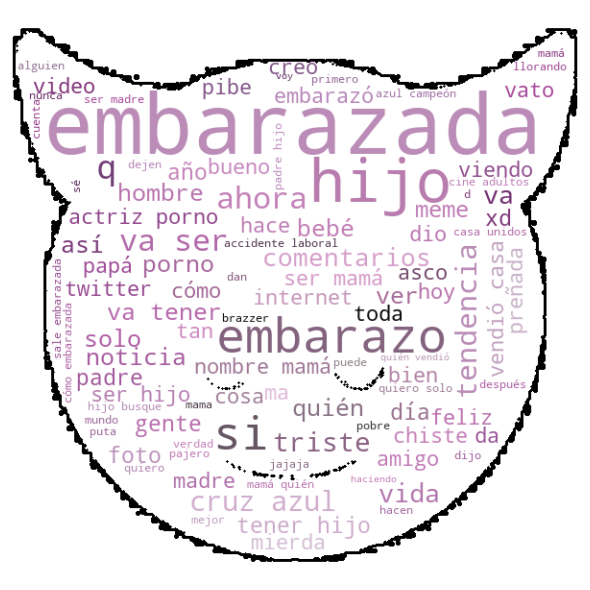

In [10]:
# CARGAR IMAGEN 
img = PIL.Image.open("emoji.jpg")
mask = np.array(img)

wordcloud = WordCloud(width=800, height=400,
                      max_font_size=150, max_words=100,
                      background_color="white", colormap="spring",
                      stopwords=stopwords, collocations=True,
                      mask=mask, contour_width=2, contour_color='black').generate(palabras) # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

image_colors=ImageColorGenerator(mask)

# wordcloud.to_file("test.png")

plt.figure(figsize=(10,8))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Clustering

Aplicamos metodos de clustering para agrupar los tuits y encontrar los terminos más relevantes de cada grupo. 

Utilizamos TF IDF para crear la matriz de palabras y sus respectivos pesos

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect.fit_transform(data.pp.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns = tfidf_vect.get_feature_names())

In [12]:
tfidf_matrix

,aa,aaaa,abajo,abandonar,abatido,abdiel,abolicionista,aborto,abras,abrir,...,ídolos,índice,ñaño,ñe,última,último,única,único,útero,ᵀⁱᵍʳᵉˢ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

## K means

Utilizaremos el metodo K-Means para realizar el agrupamiento de tuits

In [14]:
ks = []
k_inertias = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_
    
    ks.append(k)
    k_inertias.append(k_inertia)   

Mediante el metodo de la gráfica de codo determinamos la mejor cantidad de clusters a implementar 

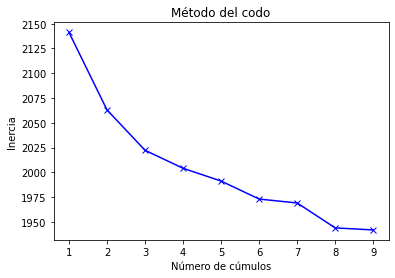

In [15]:
plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.plot(ks, k_inertias, 'bx-');

Entrenamos el modelo y agregamos una columna con el cluster asignado a cada Tuit

In [42]:
k = 3
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

data['cluster'] = model.labels_
data.sample(5)

,tweets,date,img_url,likes,texto_limpio,links,hashtags,mentions,emojis,hora,pp,cluster,sentiment
402,"Todos tristes por el embarazo de Lana Rhoades, como si tuviésemos oportunidad de hablar con ella",2021-06-02 13:59:19,None,1,"Todos tristes por el embarazo de Lana Rhoades, como si tuviésemos oportunidad de hablar con ella",[],[],[],[],2021-06-02 13:00:00,tristes embarazo si oportunidad hablar,0,0.000030
1280,"Anda sufriendo porque Lana Rhoades está preñada pero Kendra Lust tiene una hija y nadie dijo un coño, 🤷🏽‍♂️",2021-06-02 02:13:25,None,6,"Anda sufriendo porque Lana Rhoades está preñada pero Kendra Lust tiene una hija y nadie dijo un coño, 🤷🏽‍♂️",[],[],[],[🤷🏽‍♂️],2021-06-02 02:00:00,anda sufriendo preñada kendra lust hija nadie dijo coño,0,0.001912
70,¿Cómo así que Lana Rhoades va tener un hijo y no es conmigo? 😔😔\nJAJAJAJAJA,2021-06-02 20:45:24,None,0,¿Cómo así que Lana Rhoades va tener un hijo y no es conmigo? 😔😔\nJAJAJAJAJA,[],[],[],"[😔, 😔]",2021-06-02 20:00:00,cómo así va tener hijo conmigo jajajajaja,2,0.000718
451,Yo al hijo de Lana Rhoades cuando busque el nombre de su madre https://t.co/oMAsaPh55d,2021-06-02 13:01:35,http://pbs.twimg.com/media/E24Q5RmXIAMCosX.jpg,3,Yo al hijo de Lana Rhoades cuando busque el nombre de su madre,[https://t.co/oMAsaPh55d],[],[],[],2021-06-02 13:00:00,hijo busque nombre madre,2,0.001455
643,Fui a googlear quien era lana rhoades y me termine clavando una,2021-06-02 07:49:31,None,2,Fui a googlear quien era lana rhoades y me termine clavando una,[],[],[],[],2021-06-02 07:00:00,googlear termine clavando,0,0.052524


Mediante el método de Vecinos Cercanos determinamos los Tuits más cercanos a cada centroide hallado para hallar los terminos más relevantes de cada cluster

In [30]:
nbrs = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(tfidf_matrix.values)

clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)

centroides = model.cluster_centers_

In [31]:
terms = tfidf_vect.get_feature_names()
order_centroids = centroides.argsort()[:, ::-1]

for i in range(k):
    print(f"Cluster # {i}")
    print(f"Tiene {clust_cnt[i]} registros ({clust_cnt_pct[i]:.2%} de los datos)")
    print()
    print("TÉRMINOS MÁS REPRESENTATIVOS")
    for ind in order_centroids[i][:10]:
        print(terms[ind], end=" ")
    print()
    print('*****************************************************************')

Cluster # 0
Tiene 1829 registros (83.21% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
embarazada embarazo ser si va quién mamá hijo cómo porno 
*****************************************************************
Cluster # 1
Tiene 279 registros (12.69% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
hijo nombre google va tener busque mamá naciendo padre nadie 
*****************************************************************
Cluster # 2
Tiene 90 registros (4.09% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
embarazada ser tendencia cruz noticia porno gente quiero actriz quién 
*****************************************************************


## Analisis de Componentes Principales (PCA)
Se realiza PCA (de dos Componentes) al conjunto de datos ya con su respectivo cluster y representamos el resultado en un grafico de dispersión

In [32]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly.offline import iplot

pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = data.cluster.values
result['texto'] = data.pp.apply(lambda val: val[:140])

In [33]:
colorsIdx = {0: 'blue',
             1: 'yellow',
             2: 'green',
             3: 'black'
            }

result['colores'] = result['cluster'].map(colorsIdx)

result.head()

,X,Y,cluster,texto,colores
0,-0.083477,-0.107452,0,hombres serio sufren embarazo,blue
1,-0.078061,-0.101389,0,anuncia embarazo pana maestría doctorado comedia,blue
2,0.030186,-0.059877,0,si hace algun chiste pendejo embarazada realmente onvre ahí,blue
3,-0.070214,-0.074711,0,,blue
4,-0.071689,-0.080601,0,bro pensaba ere virgen,blue


In [39]:
trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['colores'].values)) 

layout = go.Layout(title="PCA")
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

## Análisis de Sentimientos
Usando la libreria `sentiment_analysis_spanish` para tweets en español, calculamos el score de sentimiento que va de 0 (negativo) a 1 (positivo) para el conjunto de tweets

In [35]:
from sentiment_analysis_spanish import sentiment_analysis

sentiment = sentiment_analysis.SentimentAnalysisSpanish()

data['sentiment'] = data['texto_limpio'].apply(lambda val: sentiment.sentiment(val))
data.head()

c:\Users\Home\Documents\Repositorios\KL-Natural_Language_Processing\env\lib\site-packages\sklearn\base.py:315: UserWarning:

Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.

c:\Users\Home\Documents\Repositorios\KL-Natural_Language_Processing\env\lib\site-packages\sklearn\base.py:315: UserWarning:

Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.



,tweets,date,img_url,likes,texto_limpio,links,hashtags,mentions,emojis,hora,pp,cluster,sentiment
0,Los hombres en serio sufren por el embarazo de Lana Rhoades? 🤣 🤣 🤣 🤣,2021-06-02 23:54:51,None,2,Los hombres en serio sufren por el embarazo de Lana Rhoades? 🤣 🤣 🤣 🤣,[],[],[],"[🤣, 🤣, 🤣, 🤣]",2021-06-02 23:00:00,hombres serio sufren embarazo,0,0.137598
1,Lana Rhoades: *anuncia su embarazo* \n\nMi pana con una maestría y un doctorado en comedia: https://t.co/M0WZxPNiuQ,2021-06-02 23:54:36,http://pbs.twimg.com/media/E26mXbCWYAIARw8.jpg,9,Lana Rhoades: *anuncia su embarazo* \n\nMi pana con una maestría y un doctorado en comedia:,[https://t.co/M0WZxPNiuQ],[],[],[],2021-06-02 23:00:00,anuncia embarazo pana maestría doctorado comedia,0,0.405654
2,"Si hace algun chiste pendejo por que Lana Rhoades está embarazada, realmente tienes un onvre ahí.",2021-06-02 23:50:17,None,0,"Si hace algun chiste pendejo por que Lana Rhoades está embarazada, realmente tienes un onvre ahí.",[],[],[],[],2021-06-02 23:00:00,si hace algun chiste pendejo embarazada realmente onvre ahí,0,0.009886
3,No me la lana Rhoades 💔😖😥😩👶 https://t.co/RLkJN3GlKU,2021-06-02 23:47:29,http://pbs.twimg.com/media/E26kNnNXMAADSAb.jpg,1,No me la lana Rhoades 💔😖😥😩👶,[https://t.co/RLkJN3GlKU],[],[],"[💔, 😖, 😥, 😩, 👶]",2021-06-02 23:00:00,,0,0.053448
4,@_paachoo_ bro pero yo pensaba que Lana Rhoades ere virgen .-.,2021-06-02 23:45:23,None,0,bro pero yo pensaba que Lana Rhoades ere virgen .-.,[],[],[@_paachoo_],[],2021-06-02 23:00:00,bro pensaba ere virgen,0,0.136403


In [37]:
print(f"El sentimiento promedio de los tweets tiene un score de {round(data['sentiment'].mean(),2)} lo cual representa un sentimiento negativo")

El sentimiento promedio de los tweets tiene un score de 0.14 lo cual representa un sentimiento negativo


In [38]:
data[["cluster","sentiment"]].groupby(["cluster"]).mean()

,sentiment
cluster,
0,0.132621
1,0.126163
2,0.430671
